In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# MODEL TREE WITH RIDGE REGRESSION

class RidgeModelTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=5, min_samples_leaf=10, ridge_alpha=1.0):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.ridge_alpha = ridge_alpha
        self.tree = None
        self.leaf_models = {}

    def fit(self, X, y):
        self.tree = DecisionTreeRegressor(
            max_depth=self.max_depth, 
            min_samples_leaf=self.min_samples_leaf
        )
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        self.leaf_models = {}
        
        for leaf in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf)[0]
            X_leaf = X.iloc[idx] if isinstance(X, pd.DataFrame) else X[idx]
            y_leaf = y.iloc[idx] if isinstance(y, pd.Series) else y[idx]

            ridge = Ridge(alpha=self.ridge_alpha)
            ridge.fit(X_leaf, y_leaf)
            self.leaf_models[leaf] = ridge
        return self

    def predict(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(len(X))
        for i, leaf in enumerate(leaf_ids):
            X_i = X.iloc[[i]] if isinstance(X, pd.DataFrame) else X[i:i+1]
            preds[i] = self.leaf_models[leaf].predict(X_i)[0]
        return preds


# Load Data
X_train = pd.read_csv("data/step3_X_train_scaled.csv")
y_train = pd.read_csv("data/step3_y_train.csv").iloc[:, 0]
X_test = pd.read_csv("data/step3_X_test_scaled.csv")
y_test = pd.read_csv("data/step3_y_test.csv").iloc[:, 0]






In [4]:
# HYPERPARAMETER OPTIMIZATION

param_grid = {
    "max_depth": list(range(5, 15)),
    "min_samples_leaf": [5, 10, 20, 50],
    "ridge_alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=RidgeModelTreeRegressor(),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("Running Grid Search for Ridge Model Tree...")
grid.fit(X_train, y_train)

print("\nBest params:", grid.best_params_)
print("Best CV score (neg MSE):", grid.best_score_)

Running Grid Search for Ridge Model Tree...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ..max_depth=5, min_samples_leaf=5, ridge_alpha=0.01; total time=   6.1s
[CV] END ...max_depth=5, min_samples_leaf=5, ridge_alpha=0.1; total time=   6.1s
[CV] END ..max_depth=5, min_samples_leaf=5, ridge_alpha=0.01; total time=   6.2s
[CV] END ..max_depth=5, min_samples_leaf=5, ridge_alpha=0.01; total time=   6.2s
[CV] END ..max_depth=5, min_samples_leaf=5, ridge_alpha=0.01; total time=   6.2s
[CV] END ..max_depth=5, min_samples_leaf=5, ridge_alpha=0.01; total time=   6.4s
[CV] END ...max_depth=5, min_samples_leaf=5, ridge_alpha=0.1; total time=   6.3s
[CV] END ...max_depth=5, min_samples_leaf=5, ridge_alpha=0.1; total time=   6.3s
[CV] END ...max_depth=5, min_samples_leaf=5, ridge_alpha=0.1; total time=   6.3s
[CV] END ...max_depth=5, min_samples_leaf=5, ridge_alpha=0.1; total time=   6.4s
[CV] END ...max_depth=5, min_samples_leaf=5, ridge_alpha=1.0; total time=   6.1s
[


Model Tree with Ridge Regression (Single)
MSE :  337.3089
RMSE:  18.3660
R^2 :  0.1982


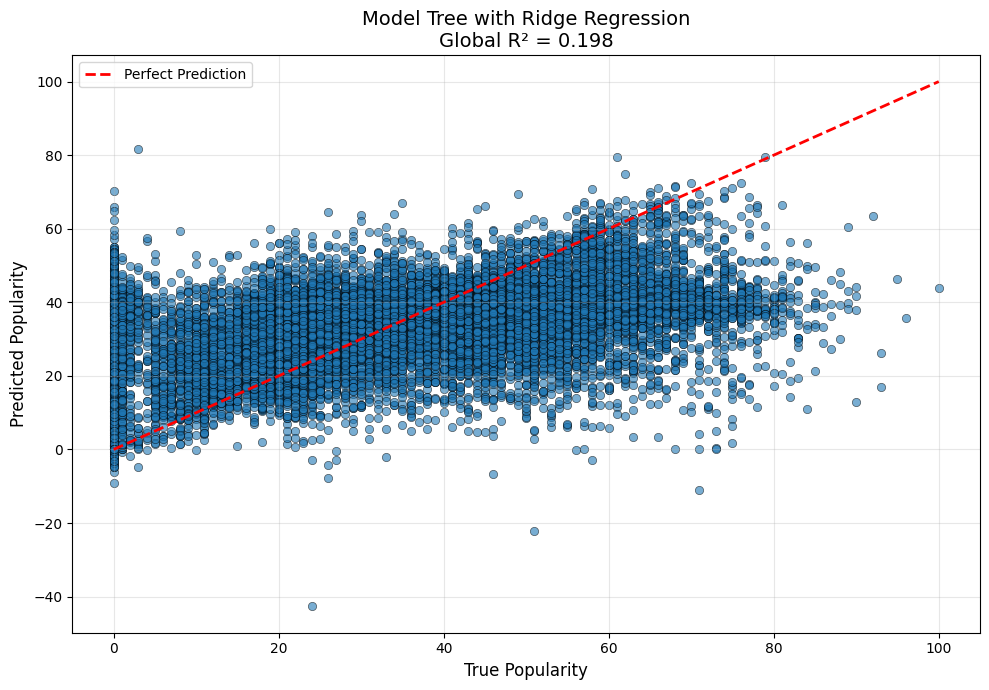

In [5]:
# SINGLE RIDGE MODEL TREE (with best params)

best_mt_ridge = RidgeModelTreeRegressor(**grid.best_params_)
best_mt_ridge.fit(X_train, y_train)
y_pred_mt_ridge = best_mt_ridge.predict(X_test)

mse_mt = mean_squared_error(y_test, y_pred_mt_ridge)
rmse_mt = np.sqrt(mse_mt)
r2_mt = r2_score(y_test, y_pred_mt_ridge)

print("\n" + "="*60)
print("Model Tree with Ridge Regression (Single)")
print("="*60)
print(f"MSE :  {mse_mt:.4f}")
print(f"RMSE:  {rmse_mt:.4f}")
print(f"R^2 :  {r2_mt:.4f}")

# Visualization: Single Ridge Model Tree
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_mt_ridge, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Model Tree with Ridge Regression\nGlobal R² = {r2_mt:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# RANDOM FOREST OF RIDGE MODEL TREES

base_mt_ridge = RidgeModelTreeRegressor(**grid.best_params_)

rf_mt_ridge = BaggingRegressor(
    estimator=base_mt_ridge,
    n_estimators=50,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

print("\nTraining Random Forest of Ridge Model Trees...")
rf_mt_ridge.fit(X_train, y_train)
y_pred_rf_mt_ridge = rf_mt_ridge.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf_mt_ridge)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf_mt_ridge)

print("\n" + "="*60)
print("Random Forest of Ridge Model Trees")
print("="*60)
print(f"MSE :  {mse_rf:.4f}")
print(f"RMSE:  {rmse_rf:.4f}")
print(f"R^2 :  {r2_rf:.4f}")


Training Random Forest of Ridge Model Trees...

Random Forest of Ridge Model Trees
MSE :  306.4759
RMSE:  17.5065
R^2 :  0.2715


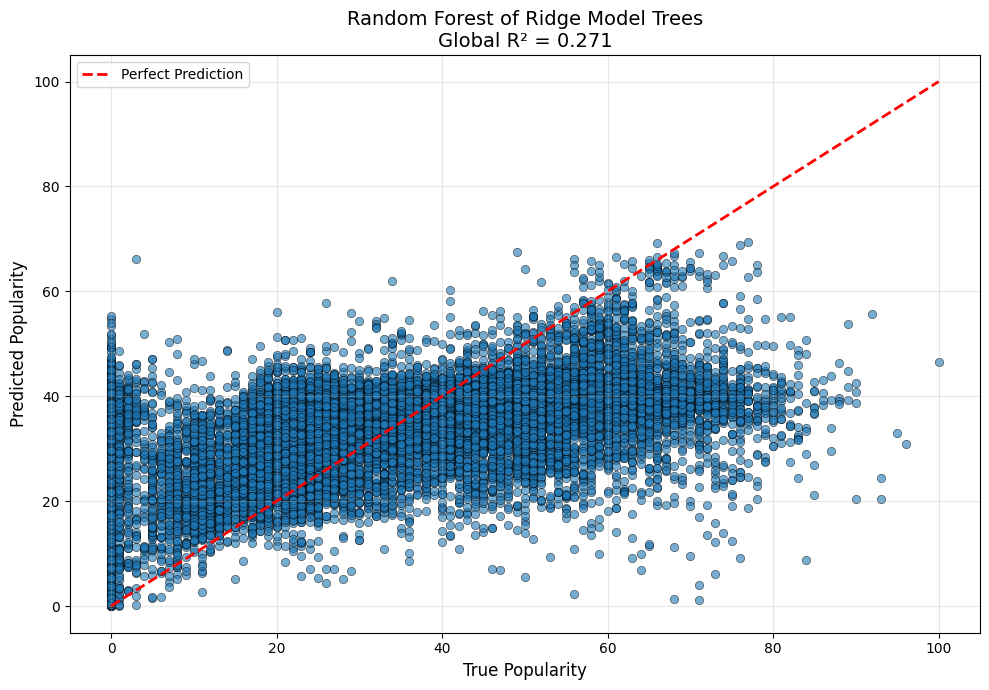

In [7]:
# Visualization: Random Forest of Ridge Model Trees
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_rf_mt_ridge, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Random Forest of Ridge Model Trees\nGlobal R² = {r2_rf:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()